Prompt:
Scanpy's ​score_genes​ just gives an enrichment value per cell but does not provide information if this enrichment is significant for the selected gene list. This might be problematic when the gene panel itself is biased as it is the case for Xenium panels. An enrichment in a certain kind of genes could lead to a biased score. How could one calculate the significance of the gene score for a particular cell?

Answer:
You're right that simply having an enrichment score without assessing its significance can be problematic, especially with biased gene panels. To calculate the significance of the gene score for a particular cell, you can use statistical methods to determine if the observed enrichment is greater than what would be expected by chance. Here are a few approaches you might consider:

1. **Permutation Testing**:
   - Randomly shuffle the gene labels many times (e.g., 1000 permutations) and calculate the enrichment score for each permutation.
   - Compare the actual enrichment score to the distribution of scores from the permutations to determine a p-value.

2. **Gene Set Enrichment Analysis (GSEA)**:
   - Use GSEA to assess whether the genes in your list are significantly enriched in the ranked list of all genes based on their expression levels in each cell.
   - This method accounts for the distribution of gene expression and can provide a significance measure.

3. **Hypergeometric Test**:
   - Use the hypergeometric test to determine if the overlap between your gene list and the set of expressed genes in a cell is greater than expected by chance.
   - This test can give you a p-value indicating the significance of the enrichment.

4. **Bootstrap Resampling**:
   - Similar to permutation testing, but instead of shuffling gene labels, you resample cells with replacement and calculate the enrichment score for each resample.
   - This can help build a distribution of scores to compare against the observed score.

5. **Adjusting for Multiple Testing**:
   - Since you are testing multiple cells, it's important to adjust for multiple comparisons using methods like Bonferroni correction or False Discovery Rate (FDR) control.

Here's a simple example of how you might implement permutation testing in Python:

In [1]:
from statsmodels.stats.multitest import fdrcorrection
import numpy as np

In [6]:
import numpy as np
import scanpy as sc

def bootstrapping_test(adata, gene_list, n_bootstrap=1000, score_name='score',
                     #ctrl_as_ref=True, ctrl_size=50, gene_pool=None, n_bins=25, random_state=0, use_raw=None
                     ):
    # Calculate the observed score
    sc.tl.score_genes(adata, gene_list, score_name=score_name,
                      #ctrl_as_ref=ctrl_as_ref, ctrl_size=ctrl_size, gene_pool=gene_pool, n_bins=n_bins, random_state=random_state, use_raw=use_raw
                      )
    observed_scores = adata.obs[score_name].values

    random_scores = np.zeros((n_bootstrap, adata.n_obs))

    genes = adata.var_names.values
    for i in range(n_bootstrap):
        # Shuffle the gene labels
        random_gene_list = np.random.choice(genes, size=len(gene_list))
        sc.tl.score_genes(adata, random_gene_list, score_name=score_name,
                          #ctrl_as_ref=ctrl_as_ref, ctrl_size=ctrl_size, gene_pool=gene_pool, n_bins=n_bins, random_state=random_state, use_raw=use_raw
                          )
        random_scores[i, :] = adata.obs[score_name].values

    # Calculate p-values
    p_values = np.mean(random_scores >= observed_scores, axis=0)

    adata.obs[score_name] = observed_scores
    adata.obs[f'{score_name}_pval'] = p_values


    # multiple testing correction
    fdrcorr = fdrcorrection(p_values, is_sorted=False)
    adata.obs[f'{score_name}_FDR'] = fdrcorr[1]

    return adata


c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\scanpy\tools\_utils.py:41: UserWarning: You’re trying to run this on 32738 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


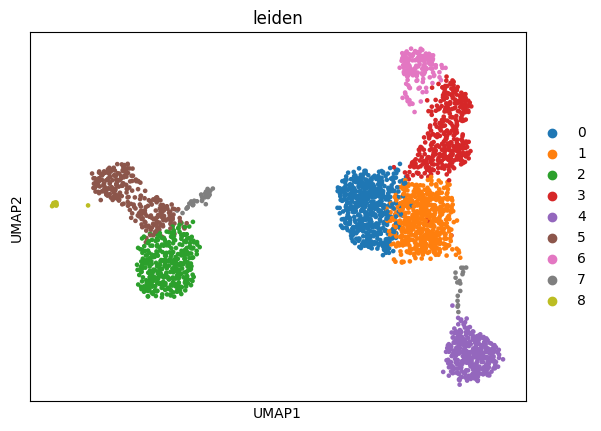

In [7]:

# Example usage
adata = sc.datasets.pbmc3k()  # Example dataset

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

# Calculate UMAP
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

# Plot the scores on UMAP
sc.pl.umap(adata, color=['leiden'])

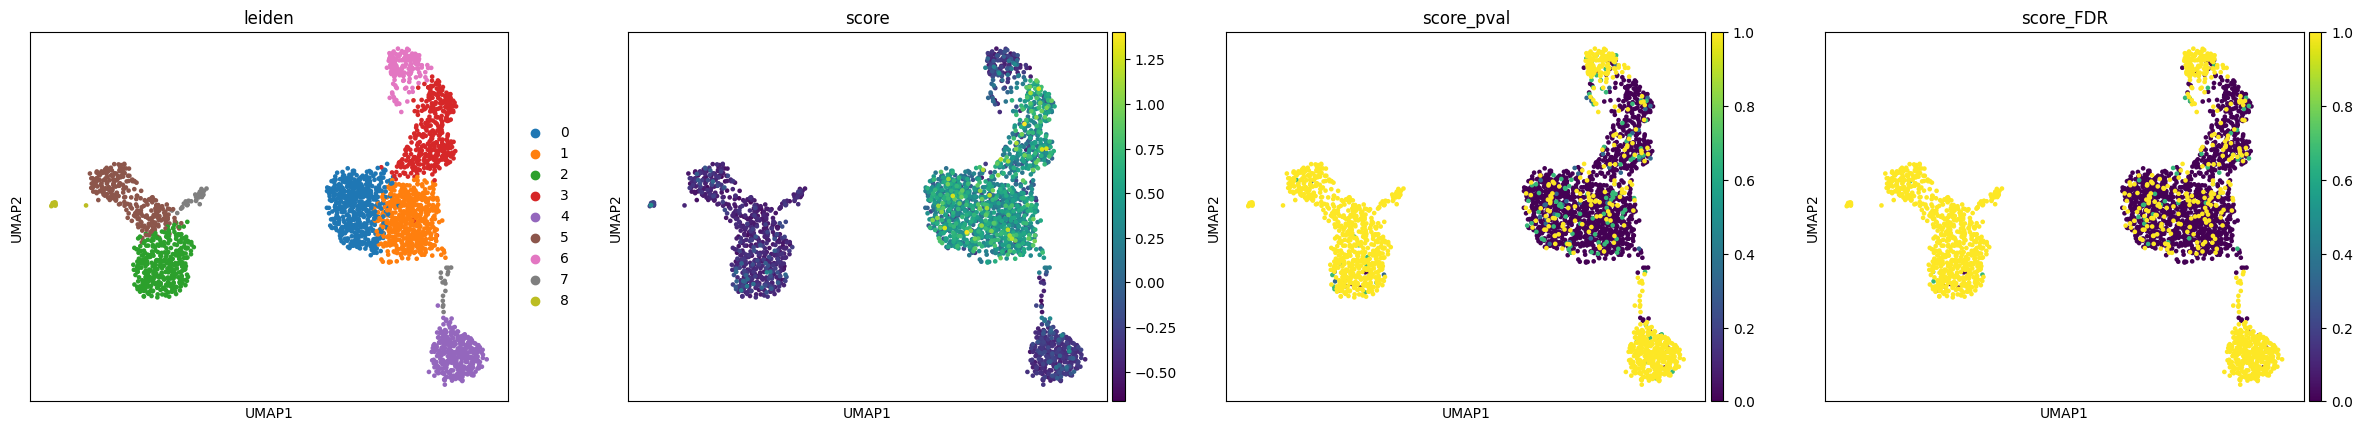

In [8]:
gene_list = ['CD3D', 'CD3E', 'CD3G']  # Example gene list
adata = bootstrapping_test(adata, gene_list, n_bootstrap=100)
sc.pl.umap(adata, color=['leiden', 'score', 'score_pval', 'score_FDR'])

In [ ]:
xd.images

In [ ]:
print(adata.obs[['score', 'score_pval']])

In [5]:
adata.obs

,score,score_pval
index,,
AAACATACAACCAC-1,-0.360000,1.0
AAACATTGAGCTAC-1,-3.460000,1.0
AAACATTGATCAGC-1,2.320000,1.0
AAACCGTGCTTCCG-1,-2.340000,1.0
AAACCGTGTATGCG-1,-0.440000,1.0
...,...,...
TTTCGAACTCTCAT-1,-2.580000,1.0
TTTCTACTGAGGCA-1,-2.780000,1.0
TTTCTACTTCCTCG-1,-1.140000,1.0


In [3]:
sc.pl.umap(adata)

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"